In [57]:
import os
import math
import json
import igraph

import numpy as np
import pandas as pd
import networkx as nx

from time import time
from pprint import pprint

from itertools import groupby
from itertools import combinations

from collections import defaultdict

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.datasets.base import Bunch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import manhattan_distances

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering

from networkx.readwrite import json_graph

from matplotlib import pyplot as plt

%matplotlib inline

In [58]:
from util import Ean
ean_checker = Ean()

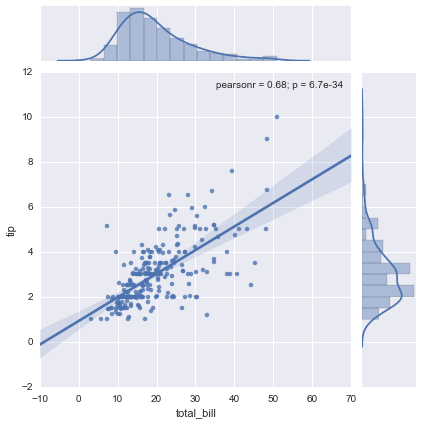

In [59]:
import seaborn as sns

# Load one of the data sets that come with seaborn
tips = sns.load_dataset("tips")

sns.jointplot("total_bill", "tip", tips, kind='reg');
 

In [60]:
def abs_dist(attr='price'):
    def _inner(a, b):
        return abs(a[attr] - b[attr])
    return _inner

In [8]:
def equal_dist(attr='name'):
    def _inner(a, b):
        if a[attr] == b[attr]:
            return 0.0
        else:
            return 1.0
    return _inner

In [9]:
class Distance:
    distances = [
        abs_dist(attr='price'),
        equal_dist(attr='name'),
    ]
    def __call__(self, a, b):
        distances = []
        for distance in self.distances:
            distances.append(distance(a, b))
        return np.array(distances)

## clean up prices

In [10]:
def convert_price(price):
    price = str(price)
    if ',' in price:
        if '.' in price:
            price = price.replace('.', '')
        price = price.replace(',', '.')
        
    if ' EUR' in price:
        price = price.replace(' EUR', '')

    try:
        return float(price)
    except ValueError:
        # print('<{}>'.format(price))
        return None

## read products feed

In [62]:
products = pd.read_csv('products.csv', error_bad_lines=False, converters={'price': convert_price})
products = products.drop('Unnamed: 0', 1)
products = products[~products.price.isnull()]
list(products.columns)

//anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


['privateid',
 'name',
 'shortdescription',
 'brand',
 'ean',
 'price',
 'type',
 'shop']

In [63]:
products.shape

(384546, 8)

## group by ean and get samples with at least 5 items

In [12]:
# dunno why this is so slow
# ean_grouped = products.groupby('ean').filter(lambda x: len(x) > 5)

In [64]:
# select only eans which appear in more than 5 shops
shops_for_ean = defaultdict(set)
for ean, shop in zip(products.ean, products.shop):
    shops_for_ean[ean].add(shop)
#print(list(shops_for_ean.items())[:10])
good_eans = {ean for ean, shops in shops_for_ean.items() if len(shops) > 5}
sample_products = products[products.ean.isin(pd.Series(list(good_eans)).sample(n=10))]
#sample_products = products[products.ean.isin(pd.Series(list(good_eans)))]
#print(sample_products.shape)

## create sample dataset

In [65]:
dataset = Bunch()
dataset.data = sample_products
dataset.target = sample_products.ean
dataset.true_k = np.unique(dataset.target).shape[0]

In [66]:
dataset.data[['shop', 'ean', 'name', 'brand', 'type', 'price']].sort(['ean'])

,shop,ean,name,brand,type,price
252734,1858,619659070960,SanDisk Extreme Pro SDHC 16GB 95MB/s SDSDXPA-0...,SanDisk,"Elektronik, Foto & Optik > Kamera & Foto > Kam...",30.99
273972,2782,619659070960,"SD-Card 16GB SanDisk Extreme PRO SDHC 95MB/s, ...",SanDisk,Speicherkarten,26.95
261058,2334,619659070960,SanDisk Extreme Pro SDHC UHS-I Karte 16GB,SANDISK,"Elektronik, Foto & Optik > Kamera & Foto > Kam...",33.22
315395,3790,619659070960,SDHC 16GB Sandisk Ex Pro C10,Sandisk,IT Katalog 2 > Speichermedien > SD-Karten >,45.95
299233,3402,619659070960,SD CARD 16GB SDHC EXTREME,SanDisk,Speichermedien / Portabel (Secure Digital Cards),26.50
276179,2784,619659070960,"SD-Card 16GB SanDisk Extreme PRO SDHC 95MB/s, ...",SanDisk,Speicherkarten,26.95
312505,3790,619659070960,SD CARD 16GB SDHC EXTREME,Sandisk,IT Katalog 1 > Speichermedien > Portable Speic...,43.95
304354,3530,619659070960,San Disk 16 GB SDHC-Karte ExtremePro,San Disk,"Elektronik, Foto & Optik > Kamera & Foto > Kam...",31.83
273199,2782,649528739100,DDR2RAM 2GB DDR2-800 Crucial,Crucial,Arbeitsspeicher & USB-Sticks,28.31
297172,3402,649528739100,2GB DDR2 800MHZ PC2-6400,Crucial,Komponenten / Speichermodule (DDR2),25.69


## feature extraction

In [67]:
class EmptyFitMixin:
    def fit(self, x, y=None):
        return self

In [68]:
class ItemSelector(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def __init__(self, key):
        self.key = key

    def transform(self, df):
        values = np.array(df[self.key])
        return values.reshape(values.shape[0], 1)

In [69]:
class TextExtractor(BaseEstimator, TransformerMixin, EmptyFitMixin):
    """Extract the text from a product in a single pass.

    Takes a pandas dataframe and produces a series of texts
    from joined columns defined in `text_cols`.
    """
    def __init__(self, text_cols=['name', 'shortdescription', 'brand', 'type']):
        self.text_cols = text_cols
    
    def transform(self, data):
        def join(items):
            return ' '.join([str(item) for item in items])
        
        texts = data[self.text_cols].apply(join, axis=1)
        return texts

In [70]:
class CosineDistance(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        cosine_similarity = linear_kernel(X, X)
        return 1.0 - cosine_similarity

In [71]:
class NumericDistance(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        return manhattan_distances(X)

In [72]:
class CombineDistances(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        parts_num = X.shape[1] / X.shape[0]
        parts = np.split(X, parts_num, axis=1)
        # combine with euclidean distance
        return np.sqrt(np.sum(p**2 for p in parts))

In [73]:
simple_features = FeatureUnion(
    transformer_list=[

        # Pipeline for pulling features from the text columns
        ('text_tfidf', Pipeline([
            # Extract text data from products
            ('text', TextExtractor(text_cols=['name', 'brand', 'type'])),
            ('tfidf', TfidfVectorizer()),
            ('svd', TruncatedSVD(2)),
            ('normalizer', Normalizer(copy=False)),
        ])),

        # Pipeline for price
        ('price', Pipeline([
            ('selector', ItemSelector(key='price')),
        ])),
    ],
)

In [74]:
pipeline_simple = Pipeline([
    # Use FeatureUnion to extract features from text and price
    ('features', simple_features),
    # Use kmeans clustering on the combined features
    ('kmeans', KMeans(n_clusters=dataset.true_k, init='k-means++', max_iter=100, n_init=1)),
])

In [29]:
#pp = sns.pairplot(sproducts, hue="ean", vars=['text_1', 'text_2', 'price'])

In [81]:
distance_features = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            # Pipeline for pulling features from the text columns
            # and build a cosine distance matrix from it
            ('text_tfidf', Pipeline([
                ('text', TextExtractor(text_cols=['name', 'brand', 'type'])),
                ('tfidf', TfidfVectorizer()),
                ('tfidf_distance', CosineDistance()),
            ])),

            # Pipeline for price
            ('price', Pipeline([
                ('selector', ItemSelector(key='price')),
                ('price_distance', NumericDistance()),
                ('normalizer', Normalizer(copy=False)),
            ])),
        ],
    )),
    ('combine', CombineDistances()),
])

In [82]:
pipeline_distances = Pipeline([
    # Use FeatureUnion to combine the features from text and price
    ('distances', distance_features),
    # Use kmeans clustering on the combined features
    ('kmeans', KMeans(n_clusters=dataset.true_k, init='k-means++', max_iter=100, n_init=1)),
])

In [77]:
#X = pipeline_distances.transform(dataset.data)
#pp = sns.pairplot(sproducts, hue="ean", vars=['text_1', 'text_2', 'price'])

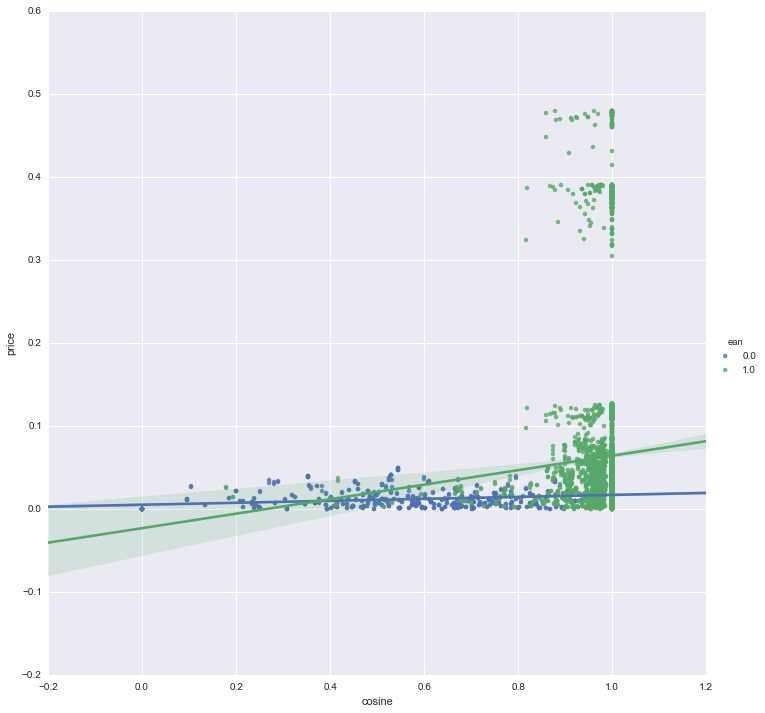

In [103]:
X_cosine_dist = pipeline_distances.steps[0][1].steps[0][1].transformer_list[0][1].fit_transform(dataset.data).flatten()
X_price_dist = pipeline_distances.steps[0][1].steps[0][1].transformer_list[1][1].transform(dataset.data).flatten()
X_ean_dist = NumericDistance().transform(ItemSelector(key='ean').transform(dataset.data)).flatten()
X_ean_dist[X_ean_dist > 0] = 1
df = pd.DataFrame({'cosine': X_cosine_dist, 'price': X_price_dist, 'ean': X_ean_dist})
#pp = sns.pairplot(df, hue="ean", vars=['cosine', 'price'], diag_kind="kde")
#sns.jointplot("cosine", "price", data=df, kind='scatter', size=10);
#sns.pairplot(df, x_vars=["cosine"], y_vars=["price"], hue="ean", size=10, kind="scatter")
sns.lmplot(x="cosine", y="price", hue="ean", data=df, size=10) # good

In [126]:
help(sns.jointplot)

Help on function jointplot in module seaborn.distributions:

jointplot(x, y, data=None, kind='scatter', stat_func=<function pearsonr at 0x109df70d0>, color=None, size=6, ratio=5, space=0.2, dropna=True, xlim=None, ylim=None, joint_kws=None, marginal_kws=None, annot_kws=None, **kwargs)
    Draw a plot of two variables with bivariate and univariate graphs.
    
    This function provides a convenient interface to the :class:`JointGrid`
    class, with several canned plot kinds. This is intended to be a fairly
    lightweight wrapper; if you need more flexibility, you should use
    :class:`JointGrid` directly.
    
    Parameters
    ----------
    x, y : strings or vectors
        Data or names of variables in ``data``.
    data : DataFrame, optional
        DataFrame when ``x`` and ``y`` are variable names.
    kind : { "scatter" | "reg" | "resid" | "kde" | "hex" }, optional
        Kind of plot to draw.
    stat_func : callable or None
        Function used to calculate a statistic ab

In [172]:
help(ax.text)

Help on method text in module matplotlib.axes._axes:

text(x, y, s, fontdict=None, withdash=False, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Add text to the axes.
    
    Add text in string `s` to axis at location `x`, `y`, data
    coordinates.
    
    Parameters
    ----------
    x, y : scalars
        data coordinates
    
    s : string
        text
    
    fontdict : dictionary, optional, default: None
        A dictionary to override the default text properties. If fontdict
        is None, the defaults are determined by your rc parameters.
    
    withdash : boolean, optional, default: False
        Creates a `~matplotlib.text.TextWithDash` instance instead of a
        `~matplotlib.text.Text` instance.
    
    Other parameters
    ----------------
    kwargs : `~matplotlib.text.Text` properties.
        Other miscellaneous text parameters.
    
    Examples
    --------
    Individual keyword arguments can be used to override any given
    par

(1064,)
(1064,)
(665,) (665,)


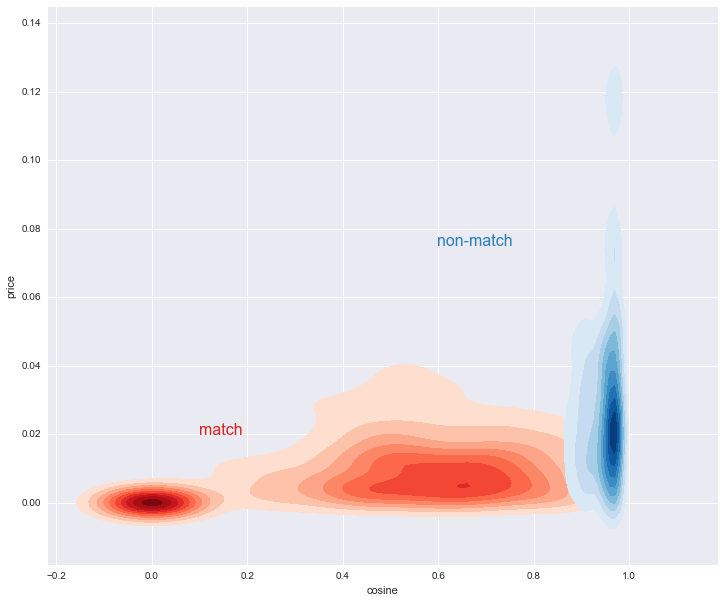

In [184]:
def match_kdeplot
    sns.set(style="darkgrid")

    pos_cosine = df['cosine'][df['ean'] == 0]
    pos_price = df['price'][df['ean'] == 0]
    neg_cosine = df['cosine'][df['ean'] == 1]
    neg_cosine = neg_cosine[neg_cosine < 0.98]
    neg_price = df['price'][df['ean'] == 1]
    neg_price = neg_price[neg_price < 0.2][:neg_cosine.shape[0]]

    # Set up the figure
    f, ax = plt.subplots(figsize=(12, 10))
    #ax.set_aspect("equal")

    # Draw the two density plots
    ax = sns.kdeplot(pos_cosine, pos_price, cmap="Reds", shade=True, shade_lowest=False)
    ax = sns.kdeplot(neg_cosine, neg_price, cmap="Blues", shade=True, shade_lowest=False)

    # Add labels to the plot
    red = sns.color_palette("Reds")[-2]
    blue = sns.color_palette("Blues")[-2]
    ax.text(0.1, 0.02, "match", size=16, color=red)
    ax.text(0.6, 0.075, "non-match", size=16, color=blue)

In [78]:
pipeline_dbscan = Pipeline([
    # Use FeatureUnion to combine the features from text and price
    ('distances', distance_features),
    # Use kmeans clustering on the combined features
    ('dbscan', SpectralClustering(n_clusters=dataset.true_k, eigen_solver='arpack')),
])

In [79]:
def evaluate_clustering(pipeline, dataset):
    pipeline.fit(dataset.data)
    #X = pipeline.transform(dataset.data)
    predicted = pipeline.fit_predict(dataset.data, dataset.target)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataset.target, predicted))
    print("Completeness: %0.3f" % metrics.completeness_score(dataset.target, predicted))
    print("V-measure: %0.3f" % metrics.v_measure_score(dataset.target, predicted))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(dataset.target, predicted))
    #print("Silhouette Coefficient: %0.3f"
    #      % metrics.silhouette_score(X, predicted, sample_size=1000))

In [37]:
#%timeit pipeline_simple.fit_predict(dataset.data)

In [80]:
evaluate_clustering(pipeline_simple, dataset)

Homogeneity: 0.452
Completeness: 0.499
V-measure: 0.475
Adjusted Rand-Index: 0.157


In [84]:
evaluate_clustering(pipeline_distances, dataset)

Homogeneity: 0.931
Completeness: 0.942
V-measure: 0.936
Adjusted Rand-Index: 0.838


In [85]:
evaluate_clustering(pipeline_dbscan, dataset)

Homogeneity: 0.855
Completeness: 0.885
V-measure: 0.870
Adjusted Rand-Index: 0.692


//anaconda/lib/python3.4/site-packages/sklearn/cluster/spectral.py:425: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


## distances to graph

In [86]:
# calc distances
X = distance_features.fit_transform(dataset.data, dataset.target)

In [87]:
# convert distance matrix to graph
dt = [('distance', float)]
G = nx.from_numpy_matrix(X.view(dt))

In [88]:
# create node color lookup dict
eans = set(dataset.data.ean)
colors = [int(c.replace('#', '0x'), 16) for c in sns.color_palette("hls", len(eans)).as_hex()]
ean_colors = {e: c for e, c in zip(eans, colors)}
node_colors = dict(enumerate((ean_colors[ean] for ean in dataset.data.ean)))

## visualize distance graph with igraph and webgl

In [91]:
# create json representation of graph, reformat node format and add color to nodes
igraph_json = json_graph.node_link_data(G)
igraph_json['nodes'] = {n['id']: {'id': n['id'], 'color': node_colors[n['id']]} for n in igraph_json['nodes']}
# reduce number of edges and rename links to edges
#igraph_json['edges'] = [l for l in igraph_json['links'] if l['distance'] < 1.0 and l['distance'] > 0.1]
igraph_json['edges'] = [l for l in igraph_json['links'] if l['distance'] < 0.8 and l['distance'] > 0.0]
#igraph_json['edges'] = igraph_json['links']
len(igraph_json['edges'])

345

In [99]:
#igraph.draw(igraph_json, size=(800, 600), directed=False)

## visualize distance graph with d3 and svg

In [96]:
# create json representation of graph, reformat node format and add color to nodes
d3_graph_json = json_graph.node_link_data(G)
d3_graph_json['nodes'] = [{'id': n['id'], 'color': node_colors[n['id']]} for n in d3_graph_json['nodes']]
pprint(d3_graph_json['nodes'][:2])
# filter links
d3_graph_json['links'] = [l for l in d3_graph_json['links'] if l['distance'] < 0.9 and l['distance'] > 0.0]
pprint(d3_graph_json['links'][:2])

# python json to javascript
from IPython.display import Javascript
#runs arbitrary javascript, client-side
Javascript("window.graph_json={};".format(json.dumps(d3_graph_json)))

[{'color': 14376791, 'id': 0}, {'color': 14376791, 'id': 1}]
[{'distance': 2.220446049250313e-16, 'source': 0, 'target': 0},
 {'distance': 2.220446049250313e-16, 'source': 0, 'target': 1}]


<IPython.core.display.Javascript object>

In [97]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [100]:
%%javascript
require(['d3'], function(d3){
  //a weird idempotency thing
  $("#chart1").remove();
  //create canvas
  var style = [
    '<style>',
    '.node {',
    '  stroke: #fff;',
    '  stroke-width: 1.5px;',
    '}',
    '.link {',
    '  stroke: #999;',
    '  stroke-opacity: .6;',
    '}',
    '</style>'
  ].join('\n');

  //element.append(style);
  element.append("<h1>distance graph</h1>")
  //element.append("<div id='chart1'></div>");
        
  var width = 960,
    height = 500;

  var color = d3.scale.category20();

  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  var svg = d3.select("#chart1").append("svg")
    .attr("width", width)
    .attr("height", height);

  var graph = window.graph_json;

  force
    .nodes(graph.nodes)
    .links(graph.links)
    .start();

  var link = svg.selectAll(".link")
    .data(graph.links)
  .enter().append("line")
    .attr("class", "link")
    .style("stroke", "#999")
    .style("stroke-width", function(d) { return 1.0; });
//    .style("stroke-width", function(d) { return d.distance / 1.0; });

  var node = svg.selectAll(".node")
    .data(graph.nodes)
  .enter().append("circle")
    .attr("class", "node")
    .attr("r", 5)
    .style("fill", function(d) { return color(d.color); })
    .call(force.drag);

  node.append("title")
    .text(function(d) { return d.id; });

  force.on("tick", function() {
    link.attr("x1", function(d) { console.log('foobar: ' + d.source.x);return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node.attr("cx", function(d) { return d.x; })
        .attr("cy", function(d) { return d.y; });
  });
});

<IPython.core.display.Javascript object>

## manual distance calculations

In [485]:
distance = Distance()
distances = []
for a, b in combinations(dataset.data, 2):
    pass
    #distances.append(distance(a, b))
len(distances)

0

In [102]:
dataset.data.ean.iloc[1]

2998949374840